### Import Packages

In [78]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import torchsummary
from alive_progress import alive_bar

### Global attributes

In [79]:
# mixed_dir = "../mixed_data/"
# clean_dir = "../clean_data/"
# nature_mixed_dir = "../classified_sound_1115/nature/mixed/"
# nature_clean_dir = "../classified_sound_1115/nature/clean/"

### Preprocess Data

In [80]:
# MelSpectrogram參數
n_mels = 128                # 保持 Mel 頻譜圖的解析度
n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
hop_length = 512            # 保持 hop_length 為 n_fft 的一半
win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
sample_rate = 16000         # 採樣率保持不變，適合語音處理
f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
duration = 5                # 音頻時長為 5 秒

In [81]:
def load_spectrogram_from_npy(mixed_dir, clean_dir):
    """Load mel spectrogram from a NumPy file."""
    mixed_mel_spectrograms = []
    clean_mel_spectrograms = []
    
    length = len(os.listdir(clean_dir))
    
    # print(f"Loading {length} files...")

    with alive_bar(length, force_tty=True) as bar:
        for filename in sorted(os.listdir(clean_dir)):
            if ".gitkeep" in filename:
                continue
            try:
                # 使用完整路徑
                mixed_path = os.path.join(mixed_dir, filename)
                clean_path = os.path.join(clean_dir, filename)
                
                mixed_mel_spectrogram_db = np.load(mixed_path)
                clean_mel_spectrogram_db = np.load(clean_path)

                # # 轉換為 PyTorch tensor 並添加通道維度
                mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                clean_mel_tensor = torch.tensor(clean_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                
                mixed_mel_spectrograms.append(mixed_mel_tensor)
                clean_mel_spectrograms.append(clean_mel_tensor)
                
                bar()
                
            except Exception as e:
                print(f"Error load file {filename}: {str(e)}")
                continue

    return mixed_mel_spectrograms, clean_mel_spectrograms

In [82]:
machine_mixed_mel_spectrograms, machine_clean_mel_spectrograms = load_spectrogram_from_npy("../machine/mixed/", "../machine/clean/")
nature_mixed_mel_spectrograms, nature_clean_mel_spectrograms = load_spectrogram_from_npy("../nature/mixed/", "../nature/clean/")
human_mixed_mel_spectrograms, human_clean_mel_spectrograms = load_spectrogram_from_npy("../human/mixed/", "../human/clean/")
mixed_mel_spectrograms = machine_mixed_mel_spectrograms + nature_mixed_mel_spectrograms + human_mixed_mel_spectrograms
clean_mel_spectrograms = machine_clean_mel_spectrograms + nature_clean_mel_spectrograms + human_clean_mel_spectrograms
target_dim = 160
pad_width = [(0, 0), (0, 0), (0, target_dim - mixed_mel_spectrograms[0].shape[2])]
mixed_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in mixed_mel_spectrograms]
clean_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in clean_mel_spectrograms]
mixed_mel_spectrograms_train, mixed_mel_spectrograms_val, clean_mel_spectrograms_train, clean_mel_spectrograms_val = train_test_split(mixed_mel_spectrograms, clean_mel_spectrograms, test_size=0.2, random_state=42)
time_steps = mixed_mel_spectrograms[0].shape[2]

|████████████████████████████████████████| 7500/7500 [100%] in 3.2s (2349.99/s)  ▄▆█ 5129/7500 [68%] in 2s (~1s, 2633. ▇▇▅ 6179/7500 [82%] in 2s (~1s, 2491.
|████████████████████████████████████████| 7500/7500 [100%] in 3.7s (2041.97/s)  ▆█▆ 3692/7500 [49%] in 2s (~2s, 1951.
|████████████████████████████████████████| 7500/7500 [100%] in 3.6s (2081.42/s) 


In [83]:
print(f'X shape = {mixed_mel_spectrograms[0].shape}')

X shape = (1, 128, 160)


### Training

In [88]:
class DenoiseAutoencoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoencoder, self).__init__()
        # 編碼器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # 全連接層 ### shape 有問題
        self.fc1 = nn.Linear(10240, 256)  # 假設輸入大小為 (1, 64, 64)
        self.fc2 = nn.Linear(256, 10240)

        # 解碼器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # 編碼器
        x = self.encoder(x)
        
        # 將特徵展平
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        # 全連接層處理
        x = self.fc1(x)
        x = self.fc2(x)
        
        # 恢復形狀為解碼器輸入
        x = x.view(batch_size, 128, 8, 10)
        # 解碼器
        x = self.decoder(x)
        return x

In [89]:
# Model參數
num_epochs = 100
batch_size = 256
learning_rate = 0.5
lr_decay_step = 20
lr_decay_gamma = 0.6

In [90]:
class AudioDataset(Dataset):
    def __init__(self, mixed_data, clean_data):
        self.mixed = mixed_data
        self.clean = clean_data
    
    def __len__(self):
        return len(self.mixed)
    
    def __getitem__(self, idx):
        return self.mixed[idx], self.clean[idx]

dataset = AudioDataset(mixed_mel_spectrograms_train, clean_mel_spectrograms_train)
dataloader = DataLoader(dataset, batch_size=batch_size)
dataloader_val = DataLoader(AudioDataset(mixed_mel_spectrograms_val, clean_mel_spectrograms_val), batch_size=len(mixed_mel_spectrograms_val))


In [91]:
from torch.optim.lr_scheduler import StepLR
model = DenoiseAutoencoder()
# example_input = torch.randn(1, 1, 128, time_steps)  # Batch size = 1, Channels = 1
# output = model(example_input)
# print("Output shape:", output.shape)  # Should be (1, 1, 128, time_steps)

# torchsummary.summary(model,(1,64,44))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)
training_losses = []
valdation_losses = []

# 訓練過程
for epoch in range(num_epochs):
    model.train()
    for (mixed, clean) in dataloader:
        
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(mixed)
        loss = criterion(outputs, clean)
            
        # 反向傳播和優化
        loss.backward()
        optimizer.step()
        
    # Step the scheduler to decay the learning rate
    scheduler.step()
    
    # count validation loss
    val_output = model(next(iter(dataloader_val))[0])
    val_loss = criterion(val_output, next(iter(dataloader_val))[1])
    valdation_losses.append(val_loss.item())
    
    training_losses.append(loss.item())
    # Optionally, print the current learning rate and loss
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.12f}, Validation Loss: {val_loss.item():.12f}, Learning Rate: {current_lr:.8f}")

Epoch [1/100], Training Loss: 690.580139160156, Validation Loss: 658.416076660156, Learning Rate: 0.50000000
Epoch [2/100], Training Loss: 196.556579589844, Validation Loss: 187.800872802734, Learning Rate: 0.50000000
Epoch [3/100], Training Loss: 123.635963439941, Validation Loss: 119.968902587891, Learning Rate: 0.50000000
Epoch [4/100], Training Loss: 85.886680603027, Validation Loss: 80.726646423340, Learning Rate: 0.50000000
Epoch [5/100], Training Loss: 54.086898803711, Validation Loss: 52.552959442139, Learning Rate: 0.50000000
Epoch [6/100], Training Loss: 40.285518646240, Validation Loss: 40.114002227783, Learning Rate: 0.50000000
Epoch [7/100], Training Loss: 32.681915283203, Validation Loss: 32.860279083252, Learning Rate: 0.50000000
Epoch [8/100], Training Loss: 28.329448699951, Validation Loss: 28.815174102783, Learning Rate: 0.50000000
Epoch [9/100], Training Loss: 25.359399795532, Validation Loss: 25.608535766602, Learning Rate: 0.50000000
Epoch [10/100], Training Loss: 

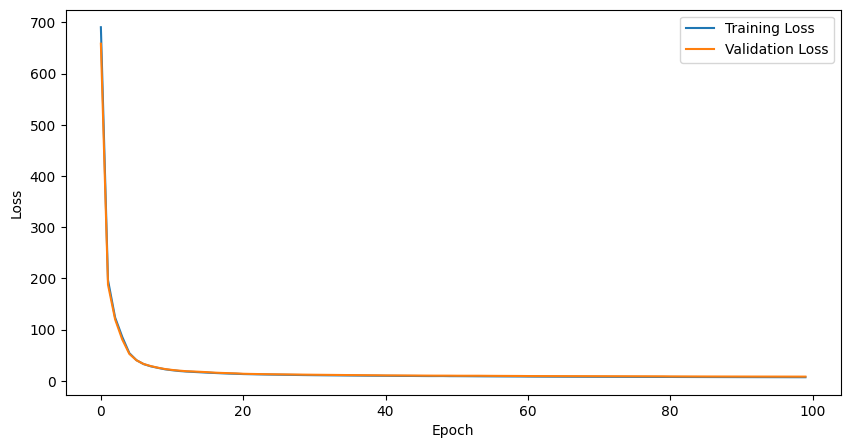

In [92]:
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label="Training Loss")
plt.plot(valdation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Prediction

In [93]:
# MelSpectrogram參數 (勿動)
n_mels = 128                # 保持 Mel 頻譜圖的解析度
n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
hop_length = 512            # 保持 hop_length 為 n_fft 的一半
win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
sample_rate = 16000         # 採樣率保持不變，適合語音處理
f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
duration = 5                # 音頻時長為 5 秒

In [94]:
# # CLEAN
# clean_waveform, sr = librosa.load('test_clean.wav', sr=sample_rate)

# if sr != sample_rate:
#     clean_waveform = librosa.resample(clean_waveform, orig_sr=sr, target_sr=sample_rate)

# clean_mel_spectrogram = librosa.feature.melspectrogram(
#     y=clean_waveform,
#     sr=sample_rate,
#     n_fft=n_fft,
#     hop_length=hop_length,
#     n_mels=n_mels
# )

# clean_mel_spectrogram_db = librosa.power_to_db(
#     clean_mel_spectrogram, 
#     ref=np.max, 
#     amin=1e-10  # 避免log(0)
# )

# clean_mel_tensor = torch.tensor(clean_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)

# clean_mel = clean_mel_tensor
# clean_output = clean_mel.squeeze(0).squeeze(0).detach().numpy()
# clean_output = librosa.db_to_power(clean_output)

# audio_signal = librosa.feature.inverse.mel_to_audio(clean_output, sr=sample_rate, n_iter=500)
# audio_signal = audio_signal / np.max(np.abs(audio_signal))


# librosa.display.waveshow(audio_signal, sr=sample_rate)
# soundfile.write('test_librosa_clean.wav', audio_signal, sample_rate)

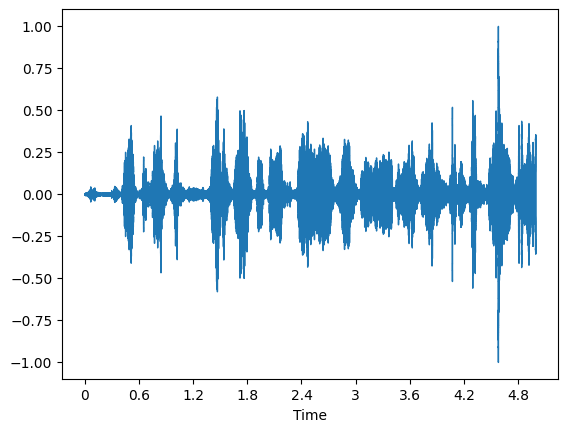

In [106]:
# MIXED
mixed_waveform, sample_rate = librosa.load('test2.wav', sr=sample_rate)

# if sr != sample_rate:
#     mixed_waveform = librosa.resample(mixed_waveform, orig_sr=sr, target_sr=sample_rate)
    
# cut to fit the duration
if len(mixed_waveform) > sample_rate * duration:
    mixed_waveform = mixed_waveform[:sample_rate * duration]

mixed_mel_spectrogram = librosa.feature.melspectrogram(
    y=mixed_waveform,
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)

mixed_mel_spectrogram_db = librosa.power_to_db(
    mixed_mel_spectrogram, 
    ref=np.max, 
    amin=1e-10  # 避免log(0)
)

# mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram, dtype=torch.float32).squeeze().unsqueeze(0)
# mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
mixed_mel_tensor = torch.tensor(np.load('nature_mixed.npy'), dtype=torch.float32).squeeze().unsqueeze(0)

mixed_mel = mixed_mel_tensor
mixed_output = mixed_mel.squeeze(0).squeeze(0).detach().numpy()
mixed_output = librosa.db_to_power(mixed_output)

audio_signal = librosa.feature.inverse.mel_to_audio(
    mixed_output,
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_iter=4096
)

audio_signal = audio_signal / np.max(np.abs(audio_signal))


librosa.display.waveshow(audio_signal, sr=sample_rate)
soundfile.write('test_librosa_mixed.wav', audio_signal, sample_rate)

torch.Size([1, 128, 157])


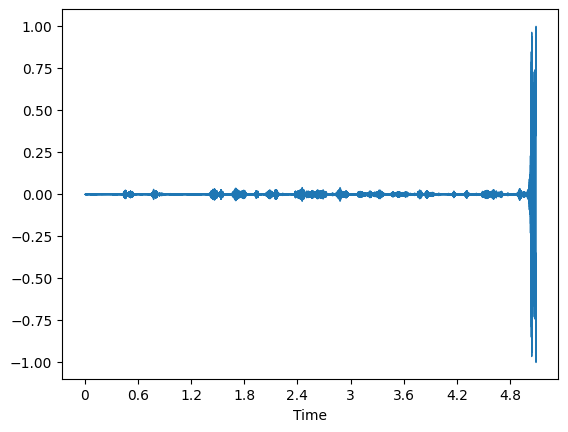

In [107]:
# DENOISED
model.eval()  # 设置模型为评估模式
print(mixed_mel_tensor.shape)
mixed_mel_tensor = torch.tensor(np.pad(mixed_mel_tensor, pad_width=pad_width, mode='constant', constant_values=0), dtype=torch.float32)
denoised_output = model(mixed_mel_tensor.unsqueeze(0))
denoised_output = denoised_output.squeeze(0).squeeze(0).detach().numpy()
denoised_output = librosa.db_to_power(denoised_output)

audio_signal = librosa.feature.inverse.mel_to_audio(denoised_output, sr=sample_rate, n_iter=500)
audio_signal = audio_signal / np.max(np.abs(audio_signal))

librosa.display.waveshow(audio_signal, sr=sample_rate)
soundfile.write('test_librosa_denoised.wav', audio_signal, sample_rate)
